In [1]:
import matplotlib.pyplot as plt
import os
from copy import copy, deepcopy

import numpy as np
np.set_printoptions(suppress=True, precision=3)

In [2]:
def get_time_stats(stats, max_time, timestep=0.05):
    current_time = 0
    current_iteration_index = 0
    time_stats = []
    while current_time <= max_time:
        while current_time < stats[current_iteration_index + 1, 1] and current_time <= max_time:
            time_stats.append([current_time, stats[current_iteration_index, 2], stats[current_iteration_index, 0]])
            current_time += timestep
        current_iteration_index += 1
    return np.array(time_stats)

In [3]:
progress_set = set()

for filename in os.scandir('../benchmarking_stats/default'):
    progress_set.add(tuple(filename.name.split(sep='.')[0].split(sep='_')[:-1]))

n_targets = 12
n_paths = 5
max_iters = 1000
max_time = 120
timestep = 0.05

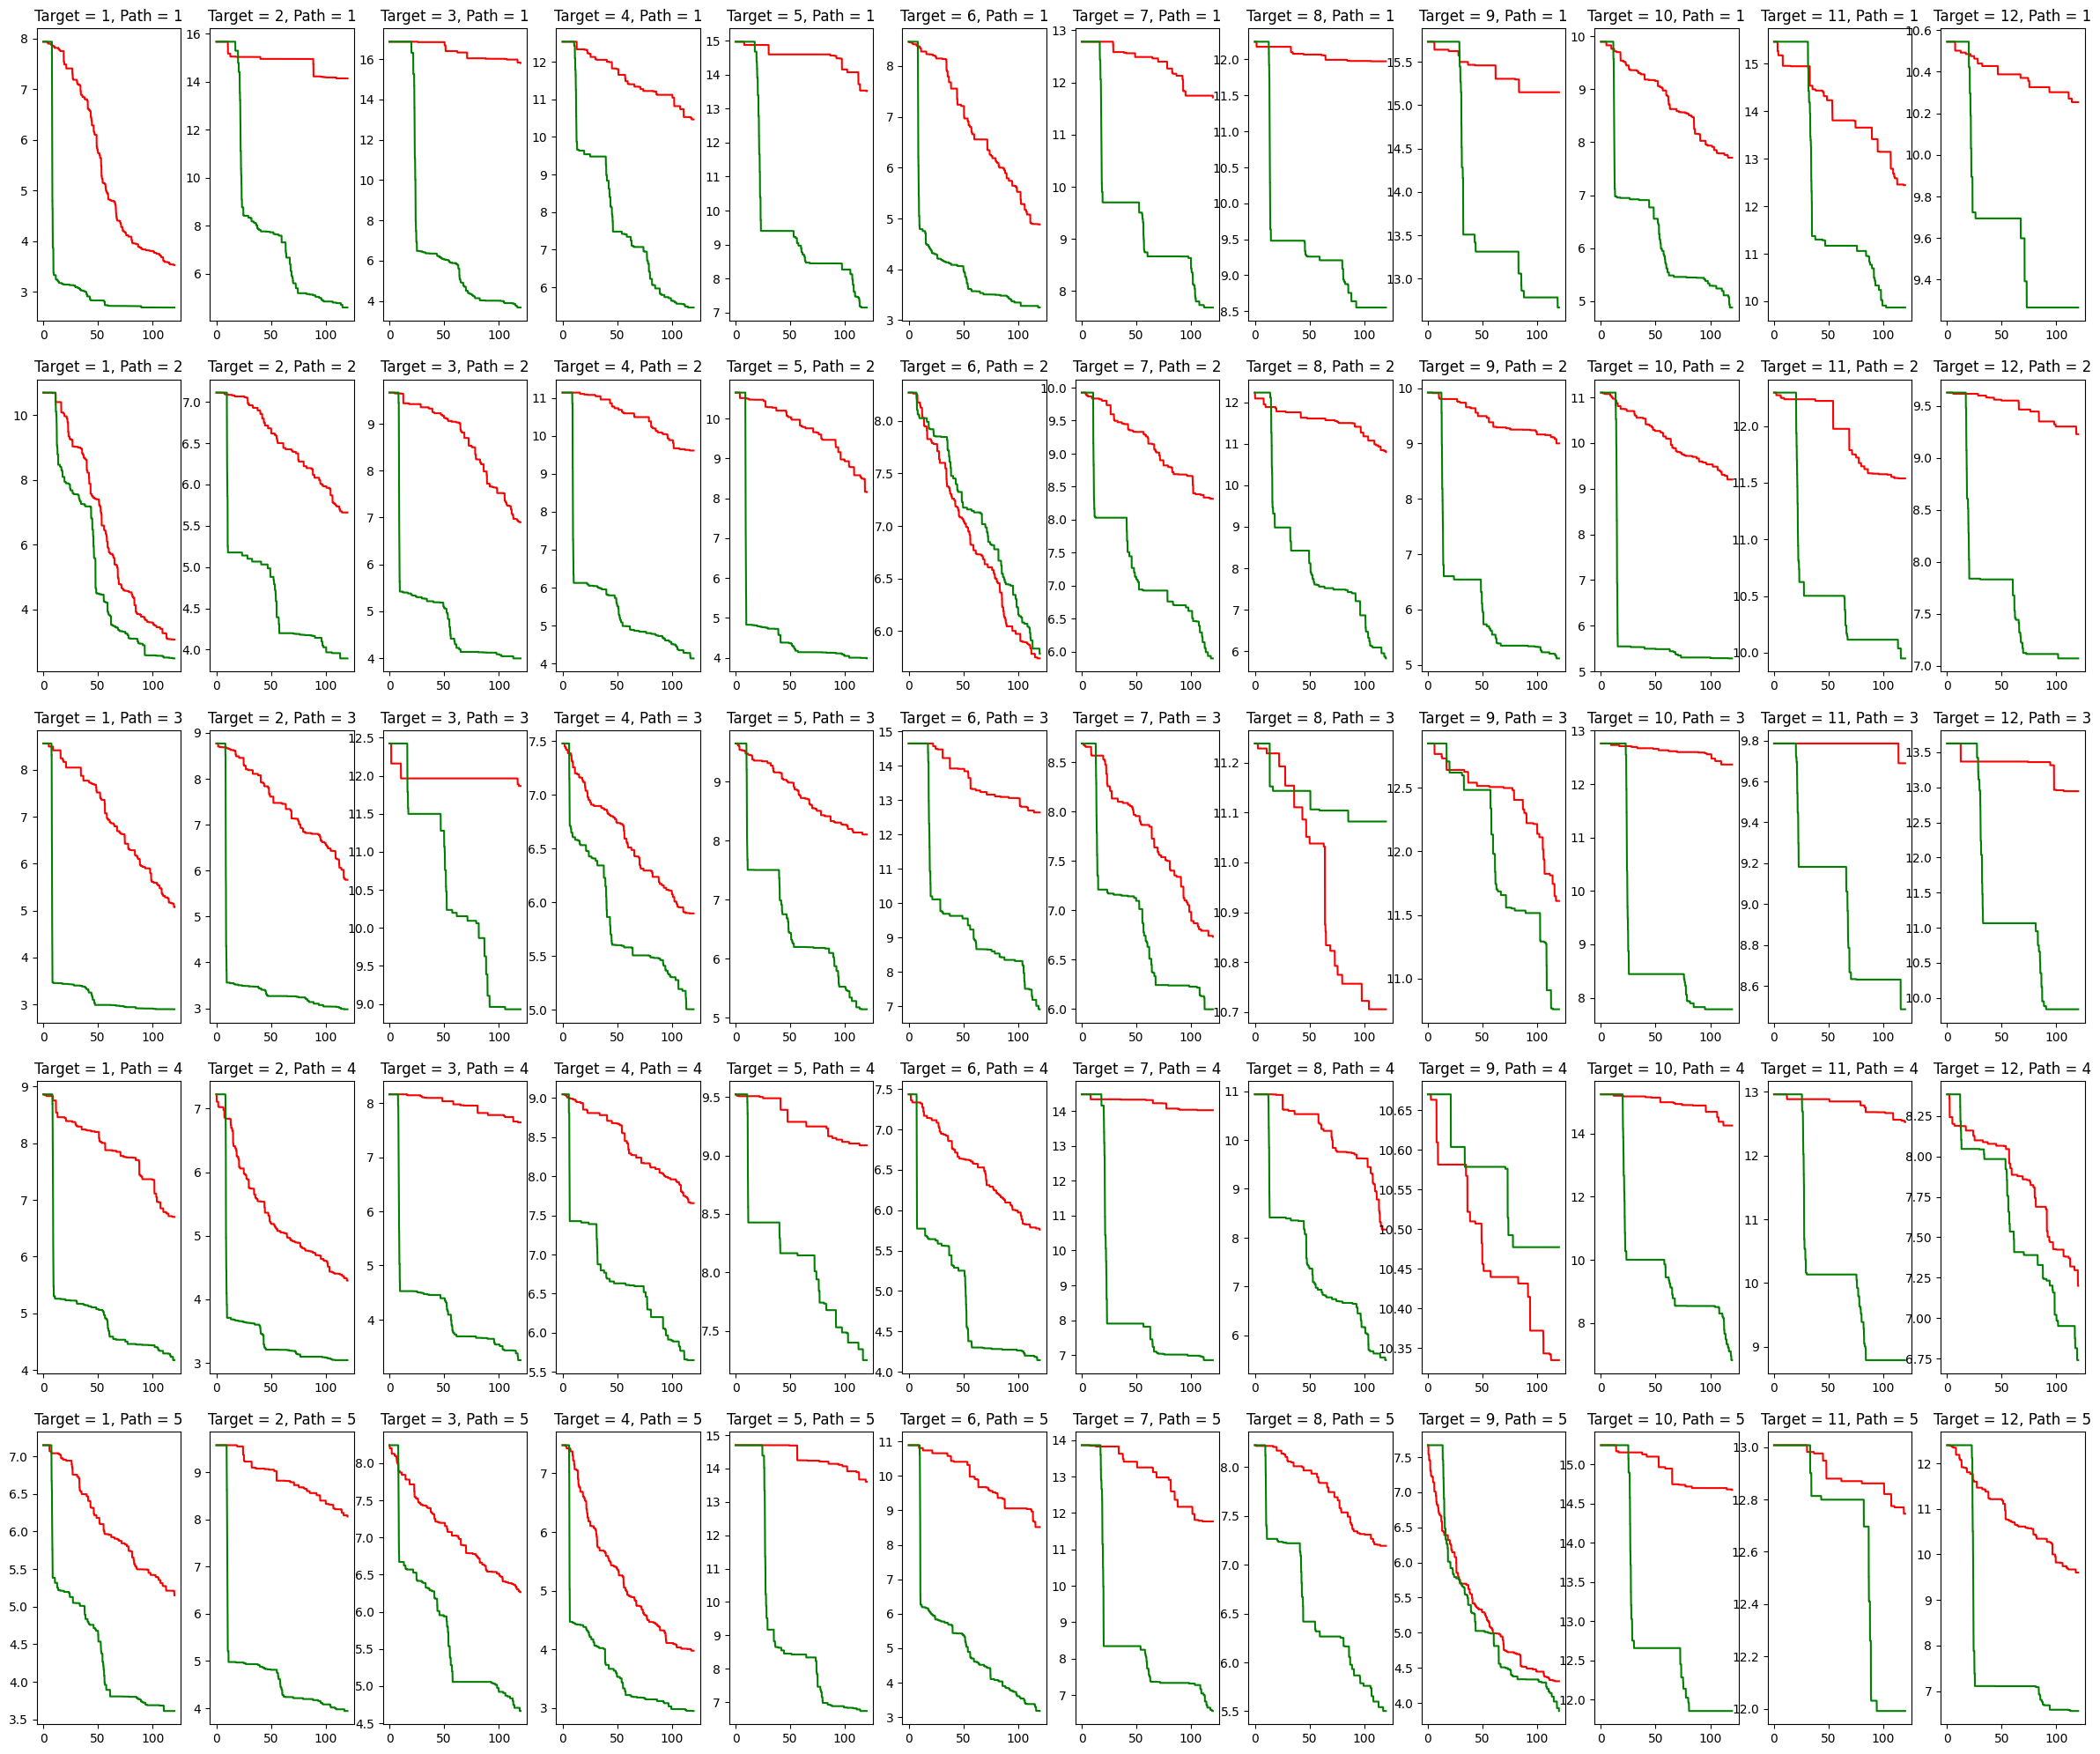

In [4]:
fig, axs = plt.subplots(n_paths, n_targets, figsize=(30, 25))
for target in range(n_targets):
    for path in range(n_paths):
        default_iters = []  
        default_time = []  
        for i in range(1, 21):
            cur_stats = np.load(f'../benchmarking_stats/default/{target+1}_{path+1}_{i}.npy')
            default_iters.append(cur_stats[:max_iters, :])
            default_time.append(get_time_stats(cur_stats, max_time, timestep))
        default_iters = np.array(default_iters)
        default_time = np.array(default_time)

        modified_iters = []  
        modified_time = []  
        for i in range(1, 21):
            cur_stats = np.load(f'../benchmarking_stats/modified/{target+1}_{path+1}_{i}.npy')
            modified_iters.append(cur_stats[:max_iters, :])
            modified_time.append(get_time_stats(cur_stats, max_time, timestep))
        modified_iters = np.array(modified_iters)
        modified_time = np.array(modified_time)

        axs[path, target].set_title(f'Target = {target+1}, Path = {path+1}')
        axs[path, target].plot(default_time.mean(axis=0)[:, 0], default_time.mean(axis=0)[:, 1], color='red')
        axs[path, target].plot(modified_time.mean(axis=0)[:, 0], modified_time.mean(axis=0)[:, 1], color='green')

plt.show()
# fig.savefig('test.png', bbox_inches='tight', dpi=400)

In [5]:
total_stats = []
total_time = []
total_paths = []

for number_target, number_path in progress_set:
    total_paths.append((number_target, number_path))
    default_time = []
    modified_time = []
    
    for i in range(1, 21):
        default_current = np.load(f'../benchmarking_stats/default/{number_target}_{number_path}_{i}.npy')
        modified_current = np.load(f'../benchmarking_stats/modified/{number_target}_{number_path}_{i}.npy')
        default_time.append(get_time_stats(default_current, max_time, timestep))
        modified_time.append(get_time_stats(modified_current, max_time, timestep))
    default_time = np.array(default_time)
    modified_time = np.array(modified_time)

    mean_diff_time = (np.median(default_time, axis=0)[:, 1] - np.median(modified_time, axis=0)[:, 1]) / np.median(default_time, axis=0)[:, 1]
    total_stats.append(mean_diff_time)
total_time = modified_time.mean(axis=0)[:, 0]

total_stats = np.array(total_stats)

In [6]:
def get_opt_time(time_stats, timestep, opt_step, max_time=120):
    opt_time = 0
    for time, cost, iter in time_stats:
        if int(iter) % opt_step == 0 and time <= max_time:
            opt_time += timestep
    return opt_time

def find_opt_eff(d_stats, m_stats, max_iters=1000, max_time=120):
    last_d_value = d_stats[-1][1]
    for time, c_best, iters in m_stats:
        if c_best < last_d_value and time <= max_time:
            if time == 0:
                print('sss')
                print(time, c_best, iters, last_d_value)
            return time / max_time
    return np.inf

In [7]:
opt_step = 300


total_relative_cost = []
total_iters_from_default = []
total_opt_times = []
opt_table = []

for number_target, number_path in progress_set:
    default_time = []
    modified_time = []

    for i in range(1, 21):
        default_current = np.load(f'../benchmarking_stats/default/{number_target}_{number_path}_{i}.npy')
        modified_current = np.load(f'../benchmarking_stats/modified/{number_target}_{number_path}_{i}.npy')
        default_time.append(get_time_stats(default_current, max_time, timestep))
        modified_time.append(get_time_stats(modified_current, max_time, timestep))
        total_opt_times.append(get_opt_time(get_time_stats(modified_current, max_time, timestep), timestep, opt_step))
    default_time = np.array(default_time)
    modified_time = np.array(modified_time)

    median_local_relative_cost = (np.median(default_time, axis=0)[:, 1] - np.median(modified_time, axis=0)[:, 1]) / np.median(default_time, axis=0)[:, 1]
    total_relative_cost.append(median_local_relative_cost)
    median_relative_iters = np.median(modified_time, axis=0)[:, 2] / np.median(default_time, axis=0)[:, 2]
    total_iters_from_default.append(median_relative_iters)

total_relative_cost = np.array(total_relative_cost) * 100
total_iters_from_default = np.array(total_iters_from_default) * 100
total_opt_times = np.array(total_opt_times)
total_time = modified_time.mean(axis=0)[:, 0]

opt_table = []

for number_target, number_path in progress_set:
    total_paths.append((number_target, number_path))
    default_time = []
    modified_time = []
    
    for i in range(1, 21):
        default_current = np.load(f'../benchmarking_stats/default/{number_target}_{number_path}_{i}.npy')
        default_time.append(get_time_stats(default_current, max_time, timestep))
    default_time = np.mean(default_time, axis=0)
    for i in range(1, 21):
        modified_current = np.load(f'../benchmarking_stats/modified/{number_target}_{number_path}_{i}.npy')
        optt_time = find_opt_eff(default_time, get_time_stats(modified_current, max_time, timestep), max_iters, max_time)
        opt_table.append(optt_time)
opt_table = np.array(opt_table)

C:\Users\Komment\AppData\Local\Temp\ipykernel_15120\638131905.py:24: RuntimeWarning: invalid value encountered in divide
  median_relative_iters = np.median(modified_time, axis=0)[:, 2] / np.median(default_time, axis=0)[:, 2]


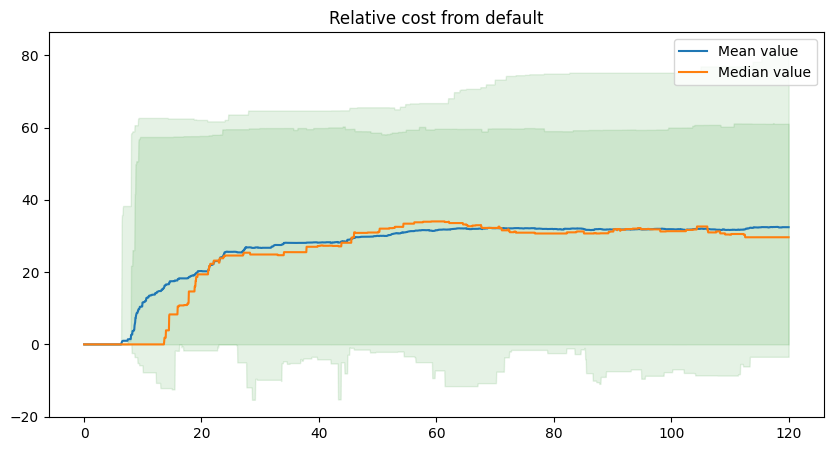

In [18]:
fig, axes = plt.subplots(figsize=(10, 5))

axes.set_title('Relative cost from default')
axes.plot(total_time, np.mean(total_stats, axis=0) * 100, label=f'Mean value')
axes.plot(total_time, np.median(total_stats, axis=0)* 100, label=f'Median value')

alphas = [0.0, 0.05]

for alpha in alphas:
    lower = np.quantile(total_stats, alpha, axis=0) * 100
    upper = np.quantile(total_stats, 1-alpha, axis=0) * 100
    axes.fill_between(total_time, lower, upper, color='green', alpha=0.1)
axes.legend()
plt.show(fig)
fig.savefig('relative_cost_profit.png', bbox_inches='tight', dpi=800)

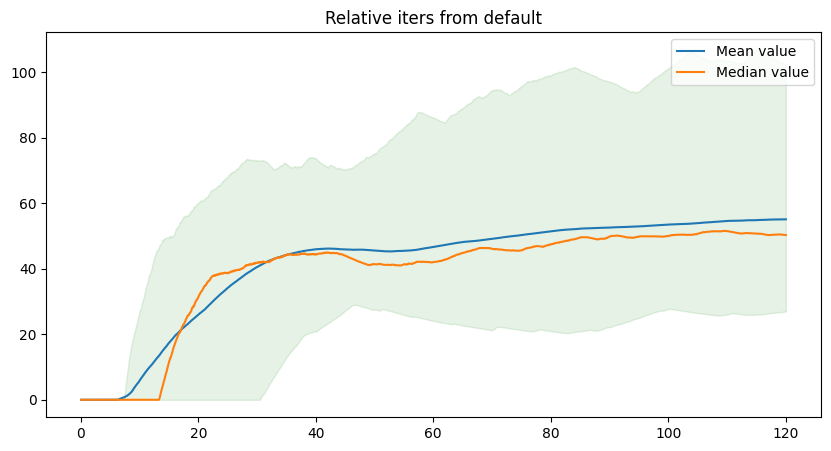

In [20]:
fig, axes = plt.subplots(figsize=(10, 5))

axes.set_title('Relative iters from default')
alphas = [0.05]

for alpha in alphas:
    lower = np.quantile(total_iters_from_default, alpha, axis=0)
    upper = np.quantile(total_iters_from_default, 1-alpha, axis=0)
    axes.fill_between(total_time, lower, upper, color='green', alpha=0.1)
axes.plot(total_time, np.mean(total_iters_from_default, axis=0), label=f'Mean value')
axes.plot(total_time, np.median(total_iters_from_default, axis=0), label=f'Median value')
axes.legend()
plt.show(fig)
fig.savefig('relative_iters.png', bbox_inches='tight', dpi=800)

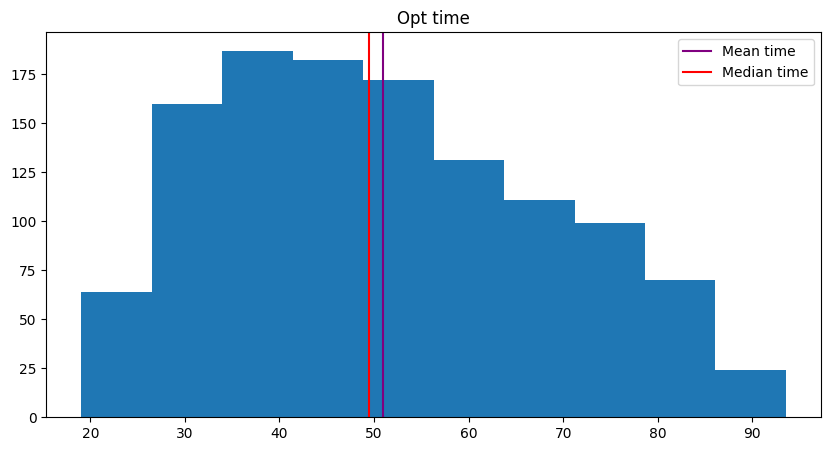

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

axs.set_title('Opt time')

axs.hist(total_opt_times, bins=10)
axs.axvline(x = total_opt_times.mean(), color = 'purple', label = 'Mean time')
axs.axvline(x = np.median(total_opt_times), color = 'red', label = 'Median time')
axs.legend()
fig.savefig('opt_time.png', bbox_inches='tight', dpi=800)

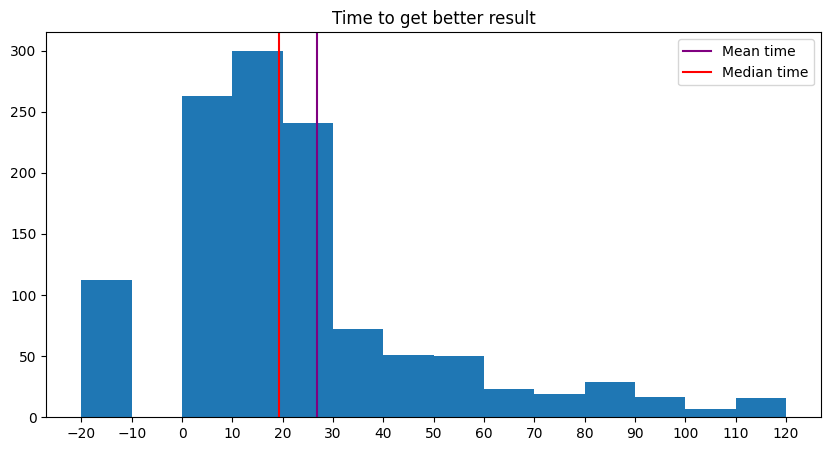

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
opt_table_vis = np.where(opt_table != np.inf, opt_table, -1/6) * max_time
opt_table_vis1 = opt_table_vis[opt_table_vis > 0]

axs.set_title('Time to get better result')
plt.xticks(np.arange(min(opt_table_vis), max(opt_table_vis) + 10, 10))
axs.hist(opt_table_vis, bins=14)
axs.axvline(x = opt_table_vis1.mean(), color = 'purple', label = 'Mean time')
axs.axvline(x = np.median(opt_table_vis1), color = 'red', label = 'Median time')
axs.legend()
fig.savefig('better_result.png', bbox_inches='tight', dpi=800)